### Predictive Analytics and Machine Learning using Python

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from math import log2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data 
df = pd.read_csv('Task1_Data_GoComedy (7).data', delimiter=',')  # or delimiter='\t' for tab
df.head()

,Age,Experience,Rank,Nationality,Go
0,36,10,9,UK,NO
1,42,12,4,USA,NO
2,23,4,6,N,NO
3,52,4,4,USA,NO
4,43,21,8,USA,YES


In [3]:
print("Original Dataset (first 10 rows):")
print(df.head(10))
print(f"\nDataset shape: {df.shape}")
print(f"Target distribution:\n{df['Go'].value_counts()}")

Original Dataset (first 10 rows):
   Age  Experience  Rank Nationality   Go
0   36          10     9          UK   NO
1   42          12     4         USA   NO
2   23           4     6           N   NO
3   52           4     4         USA   NO
4   43          21     8         USA  YES
5   44          14     5          UK   NO
6   66           3     7           N  YES
7   35          14     9          UK  YES
8   52          13     7           N  YES
9   35           5     9           N  YES

Dataset shape: (13, 5)
Target distribution:
Go
YES    7
NO     6
Name: count, dtype: int64


             Age  Experience       Rank
count  13.000000   13.000000  13.000000
mean   39.615385    8.846154   6.846154
std    13.263600    5.727800   1.908147
min    18.000000    3.000000   4.000000
25%    35.000000    4.000000   5.000000
50%    42.000000    9.000000   7.000000
75%    45.000000   13.000000   9.000000
max    66.000000   21.000000   9.000000

Categorical attributes (Nationality distribution):
Nationality
UK     5
USA    4
N      4
Name: count, dtype: int64


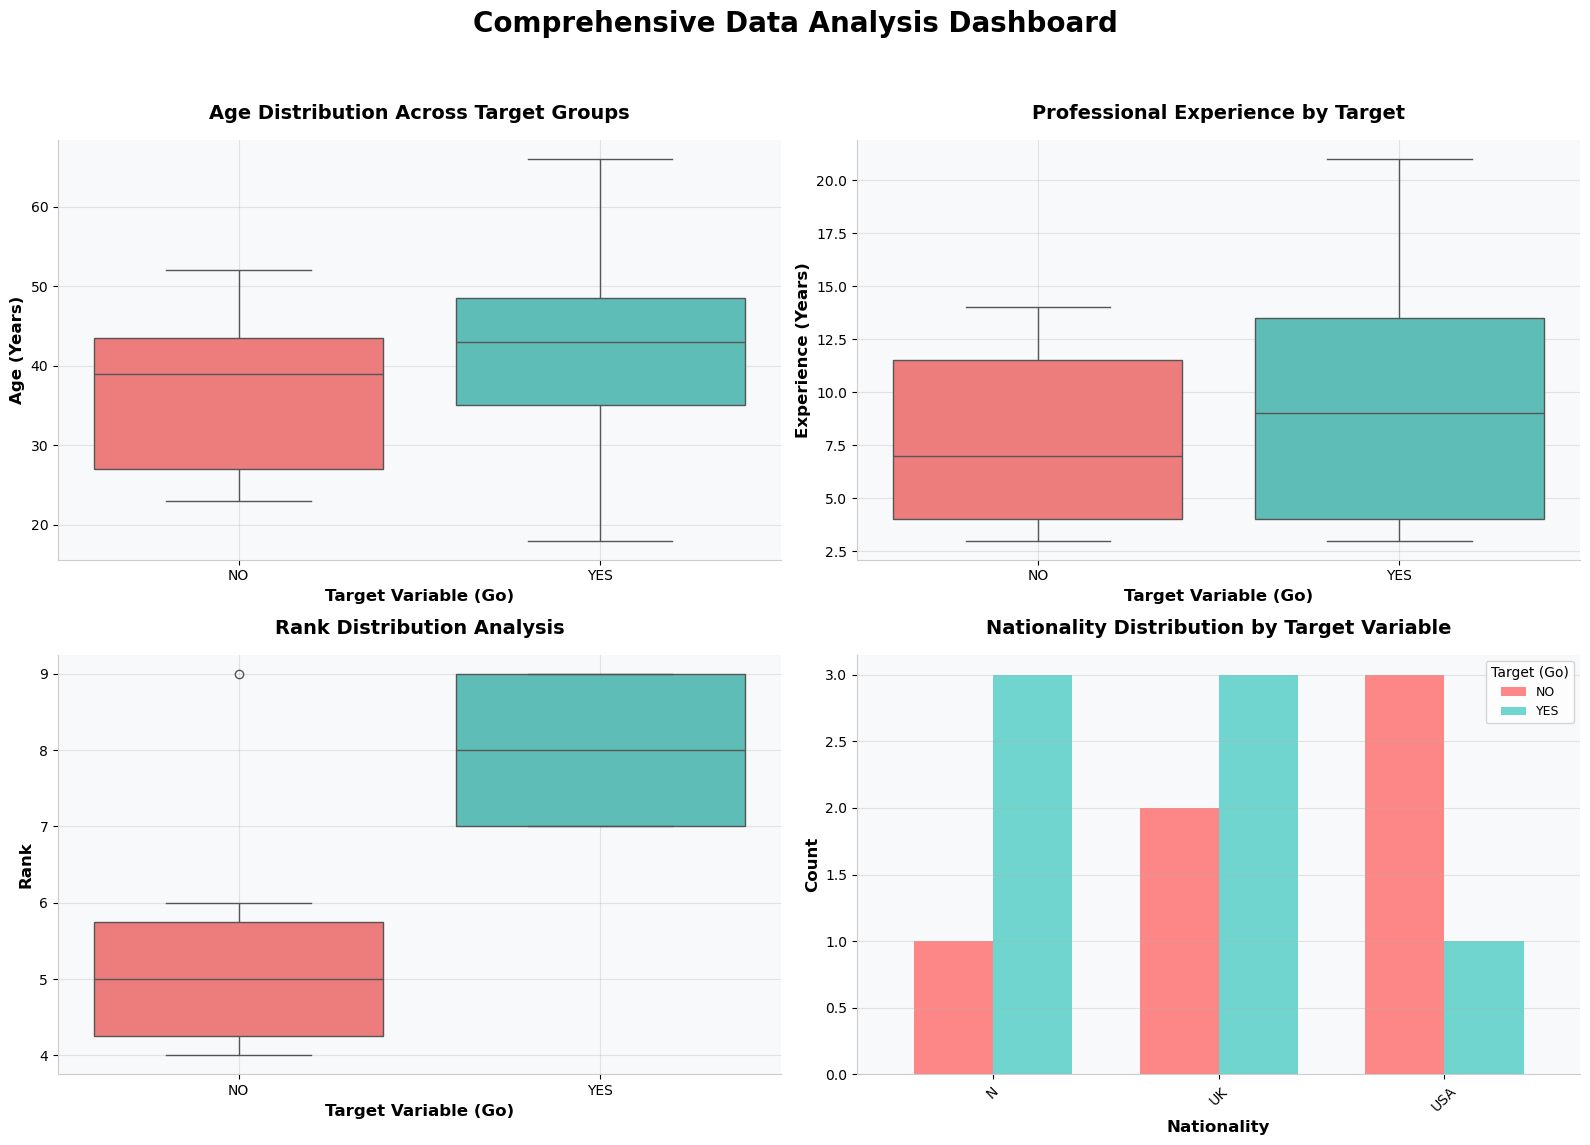

In [4]:
print(df[['Age', 'Experience', 'Rank']].describe())
print(f"\nCategorical attributes (Nationality distribution):")
print(df['Nationality'].value_counts())

# Visualization with custom colors and enhanced titles
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Data Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)

# Define color palettes
colors_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
box_colors = {'NO': '#FF6B6B', 'YES': '#4ECDC4'}  # Red and Teal for binary target

# Age Distribution
sns.boxplot(data=df, x='Go', y='Age', ax=axes[0,0], palette=box_colors)
axes[0,0].set_title('Age Distribution Across Target Groups', fontsize=14, fontweight='bold', pad=15)
axes[0,0].set_xlabel('Target Variable (Go)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Age (Years)', fontsize=12, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_facecolor('#F8F9FA')

# Experience Distribution
sns.boxplot(data=df, x='Go', y='Experience', ax=axes[0,1], palette=box_colors)
axes[0,1].set_title('Professional Experience by Target', fontsize=14, fontweight='bold', pad=15)
axes[0,1].set_xlabel('Target Variable (Go)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Experience (Years)', fontsize=12, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_facecolor('#F8F9FA')

# Rank Distribution
sns.boxplot(data=df, x='Go', y='Rank', ax=axes[1,0], palette=box_colors)
axes[1,0].set_title('Rank Distribution Analysis', fontsize=14, fontweight='bold', pad=15)
axes[1,0].set_xlabel('Target Variable (Go)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Rank', fontsize=12, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_facecolor('#F8F9FA')

# Nationality vs Target
crosstab_data = pd.crosstab(df['Nationality'], df['Go'])
crosstab_data.plot(kind='bar', ax=axes[1,1], color=colors_palette[:len(crosstab_data.columns)], 
                   alpha=0.8, width=0.7)
axes[1,1].set_title('Nationality Distribution by Target Variable', fontsize=14, fontweight='bold', pad=15)
axes[1,1].set_xlabel('Nationality', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1,1].legend(title='Target (Go)', title_fontsize=10, fontsize=9)
axes[1,1].grid(True, alpha=0.3, axis='y')
axes[1,1].set_facecolor('#F8F9FA')

# Enhanced styling
for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


plt.style.use('default') 
sns.set_palette("husl")   

In [5]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    return sum([-count/len(target_col) * log2(count/len(target_col)) 
                for count in counts])

def information_gain(data, split_attribute_name, target_name):
    total_entropy = entropy(data[target_name])
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)
    weighted_entropy = sum([(counts[i]/sum(counts)) * 
                           entropy(data.where(data[split_attribute_name]==vals[i])
                                 .dropna()[target_name]) 
                           for i in range(len(vals))])
    return total_entropy - weighted_entropy

initial_entropy = entropy(df['Go'])
print(f"Initial Entropy (Root): {initial_entropy:.4f}")

# Categorical: Nationality
ig_scores = {}
ig_scores['Nationality'] = information_gain(df, 'Nationality', 'Go')

# Numerical: test thresholds
def find_best_threshold(data, attribute, target):
    values = sorted(data[attribute].unique())
    best_ig, best_threshold = 0, None
    for i in range(len(values)-1):
        threshold = (values[i] + values[i+1]) / 2
        temp_data = data.copy()
        temp_data[f'{attribute}_split'] = temp_data[attribute] <= threshold
        ig = information_gain(temp_data, f'{attribute}_split', target)
        if ig > best_ig:
            best_ig, best_threshold = ig, threshold
    return best_ig, best_threshold

for attr in ['Age', 'Experience', 'Rank']:
    best_ig, best_threshold = find_best_threshold(df, attr, 'Go')
    ig_scores[attr] = best_ig
    print(f"Information Gain - {attr}: {best_ig:.4f} (threshold: {best_threshold})")

print(f"Information Gain - Nationality: {ig_scores['Nationality']:.4f}")

Initial Entropy (Root): 0.9957
Information Gain - Age: 0.0727 (threshold: 20.5)
Information Gain - Experience: 0.0727 (threshold: 17.5)
Information Gain - Rank: 0.6612 (threshold: 6.5)
Information Gain - Nationality: 0.1230


In [6]:
ranked_attributes = sorted(ig_scores.items(), key=lambda x: x[1], reverse=True)
print("\nRanking of attributes (highest to lowest IG):")
for i, (attr, ig) in enumerate(ranked_attributes, 1):
    print(f"{i}. {attr}: {ig:.4f}")
best_attribute = ranked_attributes[0][0]
print(f"\n BEST ROOT SPLIT: {best_attribute} (IG={ranked_attributes[0][1]:.4f})")



Ranking of attributes (highest to lowest IG):
1. Rank: 0.6612
2. Nationality: 0.1230
3. Age: 0.0727
4. Experience: 0.0727

 BEST ROOT SPLIT: Rank (IG=0.6612)


In [7]:
df_encoded = df.copy()
le_nat = LabelEncoder()
df_encoded['Nationality_encoded'] = le_nat.fit_transform(df['Nationality'])
le_target = LabelEncoder()
df_encoded['Go_encoded'] = le_target.fit_transform(df['Go'])

X = df_encoded[['Age', 'Experience', 'Rank', 'Nationality_encoded']]
y = df_encoded['Go_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

criterions = ['gini', 'entropy']
results = {}
for criterion in criterions:
    dt = DecisionTreeClassifier(criterion=criterion, random_state=42, max_depth=3)
    dt.fit(X_train, y_train)
    feature_importance = pd.DataFrame({
        'Feature': ['Age', 'Experience', 'Rank', 'Nationality'],
        'Importance': dt.feature_importances_
    }).sort_values('Importance', ascending=False)
    results[criterion] = {'model': dt, 'importance': feature_importance}
    y_pred = dt.predict(X_test)
    print(f"\n--- {criterion.upper()} Criterion ---")
    print("Feature Importances:\n", feature_importance)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


--- GINI Criterion ---
Feature Importances:
        Feature  Importance
2         Rank         1.0
0          Age         0.0
1   Experience         0.0
3  Nationality         0.0
Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4


--- ENTROPY Criterion ---
Feature Importances:
        Feature  Importance
2         Rank         1.0
0          Age         0.0
1   Experience         0.0
3  Nationality         0.0
Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg

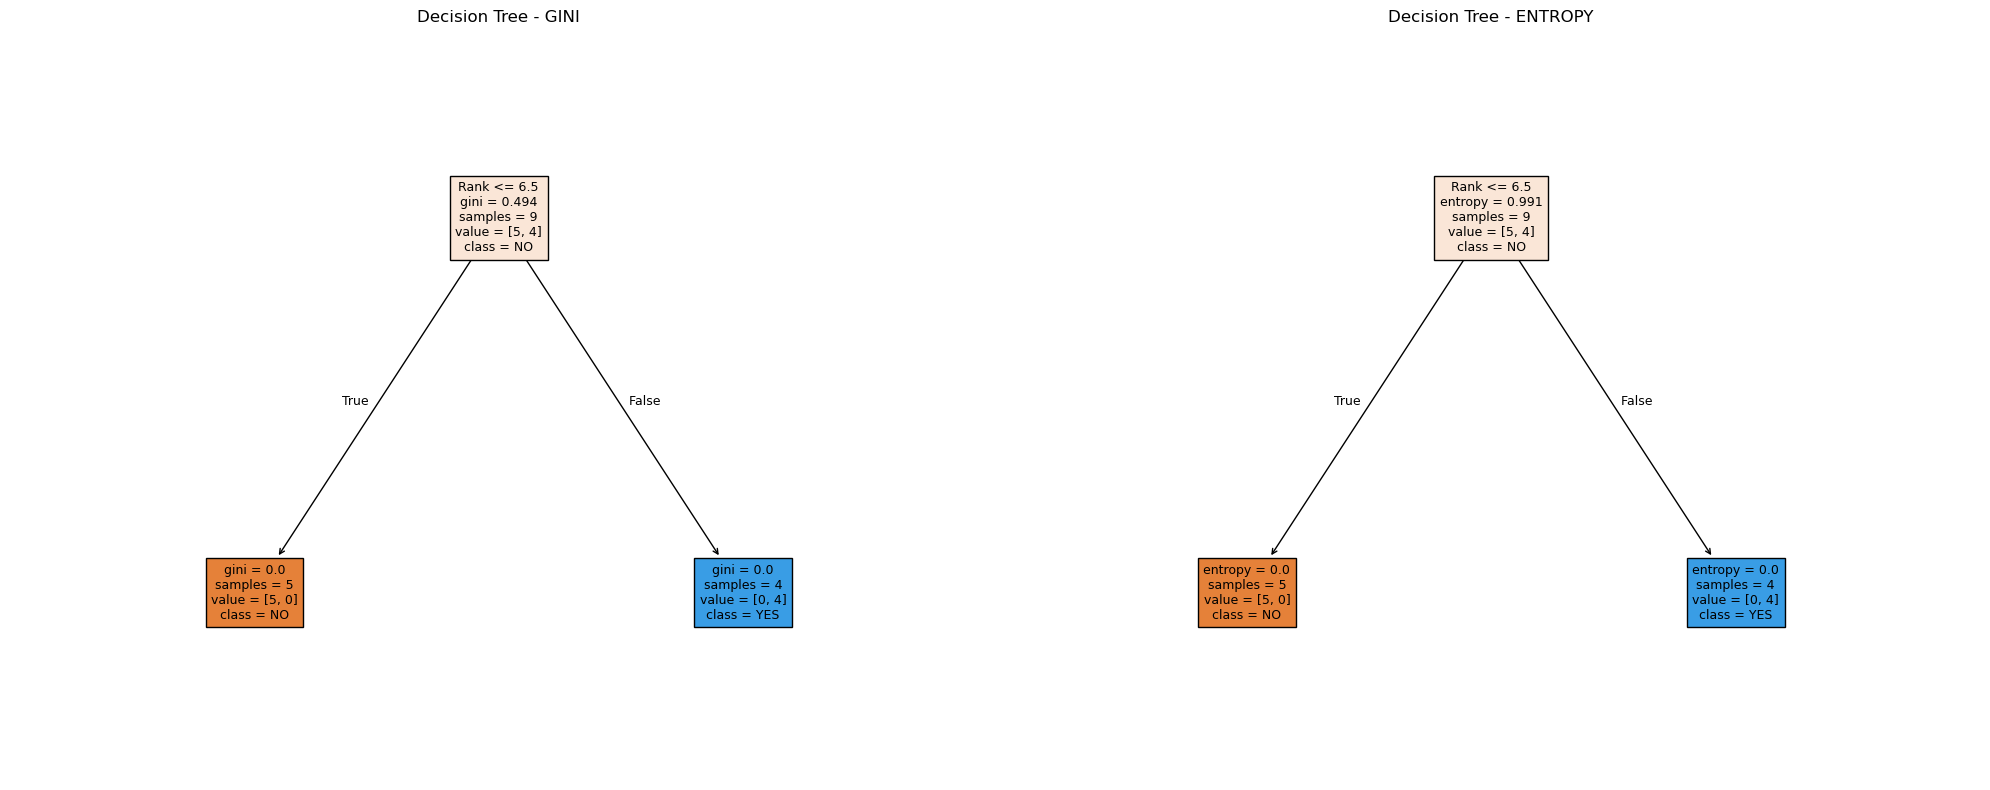

In [8]:
# ================== STEP 6: VISUALIZATION ==================
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for i, criterion in enumerate(criterions):
    plot_tree(results[criterion]['model'], ax=axes[i],
              feature_names=['Age', 'Experience', 'Rank', 'Nationality'],
              class_names=['NO', 'YES'],
              filled=True, fontsize=9)
    axes[i].set_title(f'Decision Tree - {criterion.upper()}')
plt.tight_layout()
plt.show()



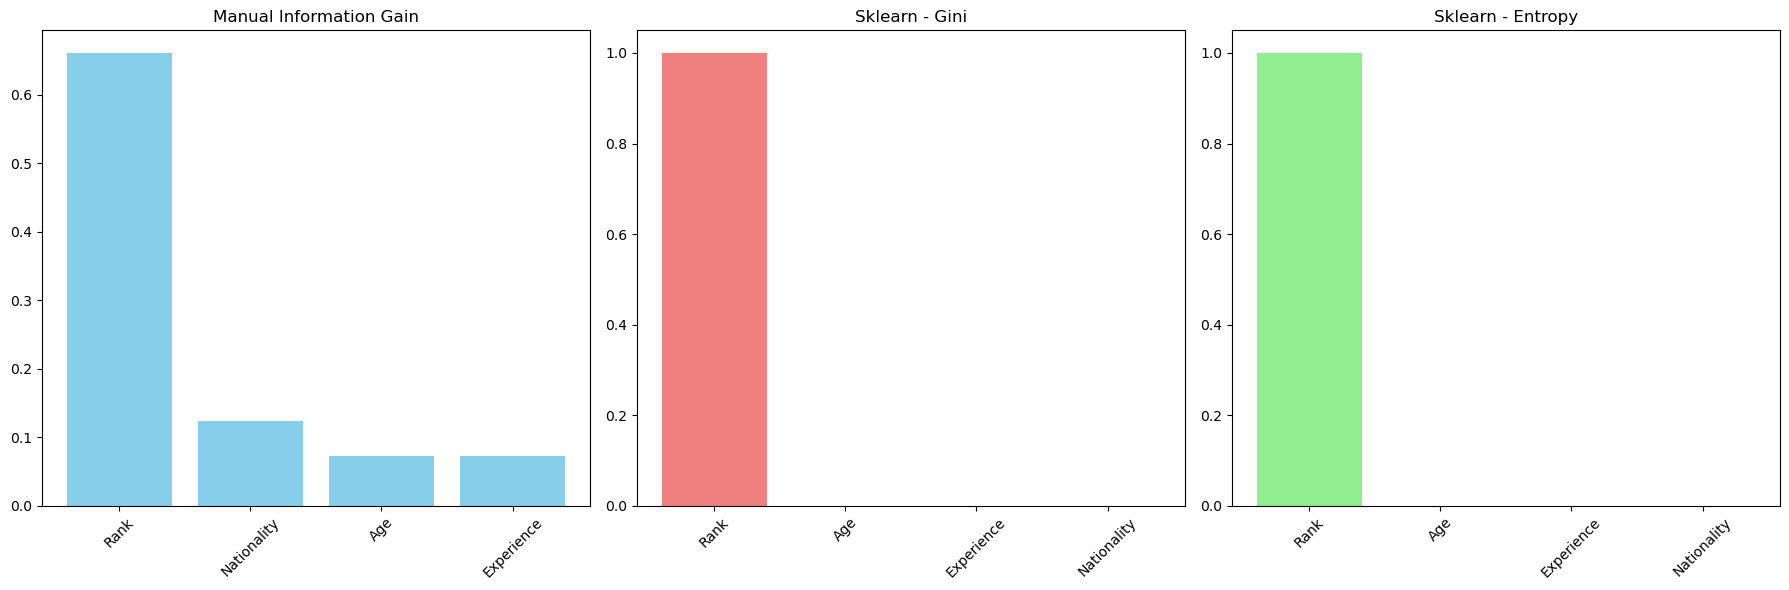

In [9]:
manual_ig = pd.DataFrame(list(ig_scores.items()), columns=['Feature','Information_Gain'])
manual_ig = manual_ig.sort_values('Information_Gain', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].bar(manual_ig['Feature'], manual_ig['Information_Gain'], color='skyblue')
axes[0].set_title('Manual Information Gain'); axes[0].tick_params(axis='x', rotation=45)
gini_imp = results['gini']['importance']
axes[1].bar(gini_imp['Feature'], gini_imp['Importance'], color='lightcoral')
axes[1].set_title('Sklearn - Gini'); axes[1].tick_params(axis='x', rotation=45)
entropy_imp = results['entropy']['importance']
axes[2].bar(entropy_imp['Feature'], entropy_imp['Importance'], color='lightgreen')
axes[2].set_title('Sklearn - Entropy'); axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()

plt.show()

In [10]:
new_data = pd.DataFrame({
    'Age': [22, 45, 35],
    'Experience': [2, 18, 10],
    'Rank': [7, 5, 8],
    'Nationality_encoded': [0, 1, 2]
})
print("\nNew data for prediction:\n", new_data)
for criterion in criterions:
    model = results[criterion]['model']
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)
    print(f"\nPredictions using {criterion.upper()}:")
    for i in range(len(new_data)):
        label = 'YES' if predictions[i]==1 else 'NO'
        print(f" Sample {i+1}: {label} (Prob NO={probabilities[i][0]:.3f}, YES={probabilities[i][1]:.3f})")



New data for prediction:
    Age  Experience  Rank  Nationality_encoded
0   22           2     7                    0
1   45          18     5                    1
2   35          10     8                    2

Predictions using GINI:
 Sample 1: YES (Prob NO=0.000, YES=1.000)
 Sample 2: NO (Prob NO=1.000, YES=0.000)
 Sample 3: YES (Prob NO=0.000, YES=1.000)

Predictions using ENTROPY:
 Sample 1: YES (Prob NO=0.000, YES=1.000)
 Sample 2: NO (Prob NO=1.000, YES=0.000)
 Sample 3: YES (Prob NO=0.000, YES=1.000)


## TASK 2

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv("daily-minimum-temperatures.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.rename(columns = {"Date": "date", "Daily minimum temperatures": "temperature"})
df.head()

###Extracting features 
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["quarter"] = df["date"].dt.quarter
df["day_of_week"] = df["date"].dt.dayofweek

# 1. Weekend vs Weekday (MOST POPULAR)
df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
print("1. WEEKEND/WEEKDAY")
print("   • is_weekend: 1 = Weekend (Sat/Sun), 0 = Weekday (Mon-Fri)")
print(f"   • Distribution: {df['is_weekend'].value_counts().to_dict()}")


# Define a function for European seasons
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Apply to your DataFrame
df["season"] = df["month"].apply(assign_season)
season_mapping = {
    'Winter': 1,
    'Autumn': 2, 
    'Spring': 3,
    'Summer': 4
}
# Apply the mapping
df['season'] = df['season'].map(season_mapping)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

1. WEEKEND/WEEKDAY
   • is_weekend: 1 = Weekend (Sat/Sun), 0 = Weekday (Mon-Fri)
   • Distribution: {0: 2607, 1: 1043}
Dataset Shape: (3650, 8)
Columns: ['date', 'temperature', 'year', 'month', 'quarter', 'day_of_week', 'is_weekend', 'season']


,date,temperature,year,month,quarter,day_of_week,is_weekend,season
0,1981-01-01,20.7,1981,1,1,3,0,1
1,1981-01-02,17.9,1981,1,1,4,0,1
2,1981-01-03,18.8,1981,1,1,5,1,1
3,1981-01-04,14.6,1981,1,1,6,1,1
4,1981-01-05,15.8,1981,1,1,0,0,1


In [13]:
# Features and target for Model 1
X1 = df[['temperature', 'year', 'month', 'quarter', 'season']]
y1 = df['is_weekend']

# Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

# Feature scaling
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

print(f"Training set: {X1_train.shape}")
print(f"Test set: {X1_test.shape}")
print(f"Target distribution: {y1.value_counts().to_dict()}")

# Train model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X1_train_scaled, y1_train)

# Predictions
y1_pred = lr_model.predict(X1_test_scaled)
y1_pred_proba = lr_model.predict_proba(X1_test_scaled)[:, 1]

# Metrics
accuracy_lr = accuracy_score(y1_test, y1_pred)
roc_auc_lr = roc_auc_score(y1_test, y1_pred_proba)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")

# Feature coefficients
feature_coef_lr = pd.DataFrame({
    'feature': X1.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nFeature Coefficients:")
print(feature_coef_lr)

print("\nClassification Report:")
print(classification_report(y1_test, y1_pred))


Training set: (2920, 5)
Test set: (730, 5)
Target distribution: {0: 2607, 1: 1043}
Accuracy: 0.7137
ROC-AUC: 0.4618

Feature Coefficients:
       feature  coefficient
0  temperature    -0.077842
3      quarter    -0.046002
2        month     0.036792
1         year    -0.018838
4       season    -0.009791

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       521
           1       0.00      0.00      0.00       209

    accuracy                           0.71       730
   macro avg       0.36      0.50      0.42       730
weighted avg       0.51      0.71      0.59       730



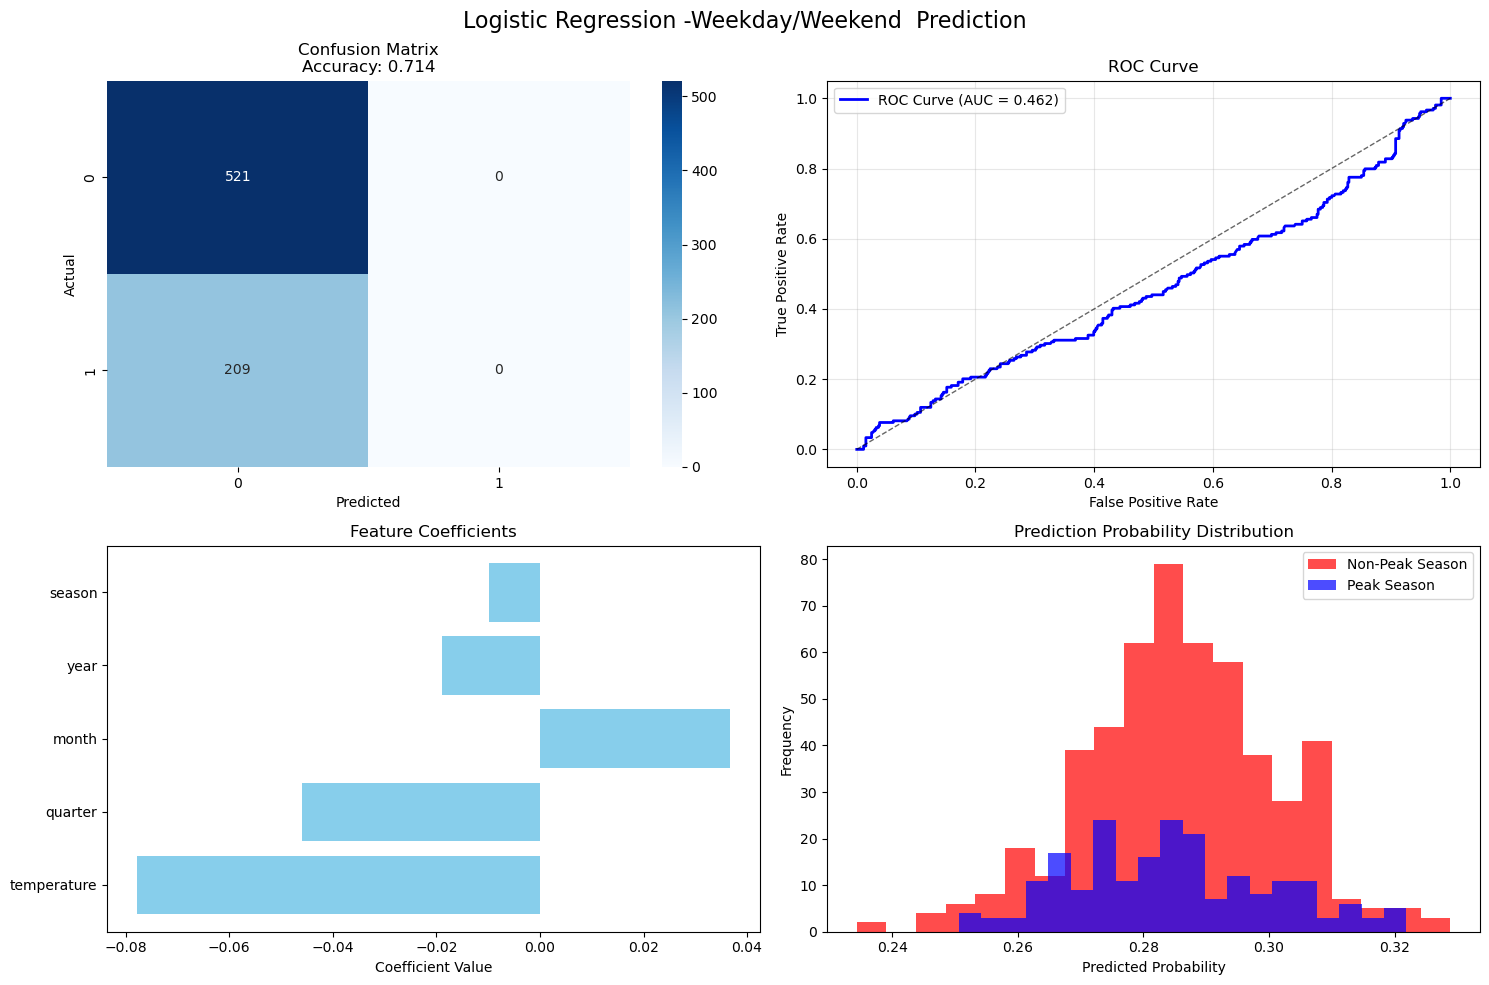

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Logistic Regression -Weekday/Weekend  Prediction', fontsize=16)

# Confusion Matrix
cm1 = confusion_matrix(y1_test, y1_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title(f'Confusion Matrix\nAccuracy: {accuracy_lr:.3f}')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
fpr1, tpr1, _ = roc_curve(y1_test, y1_pred_proba)
axes[0,1].plot(fpr1, tpr1, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=0.6)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Feature Coefficients
axes[1,0].barh(feature_coef_lr['feature'], feature_coef_lr['coefficient'], color='skyblue')
axes[1,0].set_title('Feature Coefficients')
axes[1,0].set_xlabel('Coefficient Value')

# Prediction Probabilities
axes[1,1].hist(y1_pred_proba[y1_test == 0], bins=20, alpha=0.7, label='Non-Peak Season', color='red')
axes[1,1].hist(y1_pred_proba[y1_test == 1], bins=20, alpha=0.7, label='Peak Season', color='blue')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Prediction Probability Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## TASK 3

In [15]:
# Using Exponential Regression (Curve fitting with SciPy)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Dataset
df = pd.read_csv("Task3_Data_TimeSeriesRegression.csv")

# Define exponential function model
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Fit the model
xdata, ydata = df["t"].values, df["f(t)"].values
popt, _ = curve_fit(exp_func, xdata, ydata, maxfev=10000)

# Predictions
y_pred = exp_func(xdata, *popt)

# Evaluation
mse = mean_squared_error(ydata, y_pred)
r2 = r2_score(ydata, y_pred)

print("Exponential Fit Parameters: a=%.4f, b=%.4f, c=%.4f" % tuple(popt))
print("MSE:", mse)
print("R²:", r2)

Exponential Fit Parameters: a=-10029054.3953, b=0.0000, c=10029334.5689
MSE: 104934.71995022682
R²: 0.5636224401209045


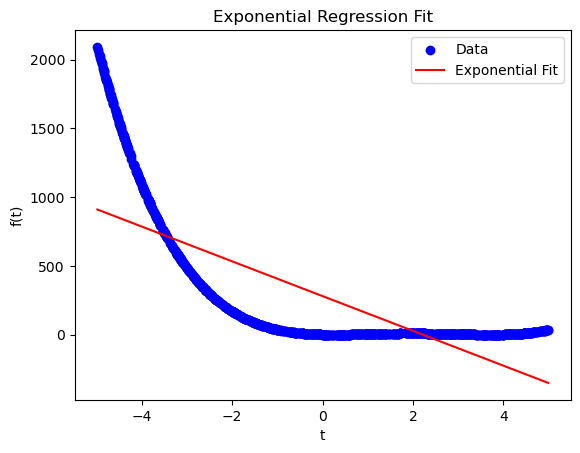

In [16]:
# Plot
plt.scatter(xdata, ydata, label="Data", color="blue")
plt.plot(sorted(xdata), exp_func(np.sort(xdata), *popt), color="red", label="Exponential Fit")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.title("Exponential Regression Fit")
plt.show()
